# Climate Data Insights: Clustering and Anomaly Detection

## 📝 Abstract
This project explores unsupervised learning methods to analyze climate-related datasets.  
In the first project, I focused on cleaning, merging, and visualizing the data to ensure quality.  
In this second project, I applied clustering (KMeans) and anomaly detection (Isolation Forest) to uncover hidden patterns and outliers.  

A dataset integrating CO₂ emissions, economic indicators, population, and renewable energy adoption was analyzed to identify structural patterns across countries. 
Growth-based indicators such as CO₂ growth, GDP growth, renewable energy share, and CO₂ intensity were constructed to capture both historical and dynamic trends.

K-Means clustering revealed three distinct groups of economies: 
(i) mid-industrializing economies with moderate GDP per capita and steadily increasing emissions, 
(ii) advanced economies with high GDP per capita and declining emissions, and 
(iii) high-emission legacy economies characterized by historically massive carbon contributions and still-rising CO₂. 

Anomaly detection further highlighted countries and years with significant deviations from their cluster profiles, providing insights into outliers such as periods of rapid industrialization or unusually high emission reductions. These findings underscore the heterogeneous nature of global emission trajectories and highlight the role of machine learning in uncovering structural and anomalous behaviors in sustainability data.


## 1. Introduction
Climate data is often large, noisy, and difficult to interpret without advanced methods.  
Unsupervised learning provides tools to reveal structure in the data without predefined labels.  

- **Clustering** groups similar records, helping to identify patterns.  
- **Anomaly detection** highlights unusual events, which may correspond to rare phenomena or data errors.  

This project builds on my project 1 work (data cleaning, merging, and visualization) by adding machine learning insights.

## 2. Methodology

### 2.1 Dataset
- Data was collected, cleaned, and merged in project 1.  
- The processed dataset contained both numerical and categorical variables.  


In [49]:
#Importing essential libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

In [50]:
#Load datasets

renewable_df=pd.read_csv('../data/renewable_energy.csv')
population_df=pd.read_csv('../data/population.csv')
co2_df=pd.read_csv('../data/co2_emissions.csv')
gdp_df=pd.read_csv('../data/gdp_percapita.csv')

#Quick preview
gdp_df.head()

,Entity,Code,Year,"GDP per capita, PPP (constant 2021 international $)",World regions according to OWID
0,Afghanistan,AFG,2000,1617.8264,NaN
1,Afghanistan,AFG,2001,1454.1108,NaN
2,Afghanistan,AFG,2002,1774.3087,NaN
3,Afghanistan,AFG,2003,1815.9282,NaN
4,Afghanistan,AFG,2004,1776.9182,NaN


In [51]:
# Data cleaning
'''
- Remove unnecessary columns
- Standardize column names
- Keep only required features
'''

gdp_df.drop(columns=['World regions according to OWID'], inplace=True)
renewable_df.drop(columns=['Code'], inplace=True)
cols_to_keep=['country', 'year', 'co2', 'co2_per_capita','coal_co2', 'oil_co2', 'gas_co2',]
co2_df=co2_df[cols_to_keep].copy()
drop_rows= ['High-income countries', 'World', 'International shipping', 'Asia (GCP)', 'Asia (excl. China and India)', 'Africa (GCP)', 'Central America (GCP)', 'Europe (GCP)', 'Europe (excl. EU-27)',
       'Europe (excl. EU-28)', 'European Union (27)',
       'European Union (28)', 'International aviation', 'International shipping', 'Kuwaiti Oil Fires (GCP)', 'Low-income countries',
       'Lower-middle-income countries', 'Middle East (GCP)', 'Non-OECD (GCP)', 'North America (GCP)', 'North America (excl. USA)', 'OECD (GCP)', 'Oceania (GCP)', 'South America (GCP)', 'Upper-middle-income countries']
co2_df=co2_df[~co2_df['country'].isin(drop_rows)].copy()

gdp_df=gdp_df.rename(columns={'Entity': 'country', 'Year': 'year', 'GDP per capita, PPP (constant 2021 international $)': 'gdp_per_capita'})
population_df= population_df.rename(columns={'Entity': 'country', 'Year': 'year', 'all years': 'population'})
renewable_df.rename(columns={'Entity': 'country', 'Year': 'year', 'Renewables (% equivalent primary energy)': 'renewable_energy_consumption'}, inplace=True)

In [52]:
# Checking for missing values

print(renewable_df.isna().sum())
print(gdp_df.isna().sum())
print(population_df.isna().sum())

gdp_df=gdp_df.dropna(subset=['gdp_per_capita'])

#Creating new csv files of cleaned dataset
gdp_df.to_csv("gdp_cleaned_dataset.csv", index=False)
renewable_df.to_csv("renewable_cleaned_dataset.csv", index=False)
population_df.to_csv("population_cleaned_dataset.csv", index=False)

# Identify top CO2 emitting countries
emissions = co2_df.groupby("country")["co2"].sum().sort_values(ascending=False)
top_emitters = emissions.head(75).index.tolist()

# Select reliable smaller emitters
null_ratio = co2_df.groupby("country")["co2"].apply(lambda x: x.isnull().mean())
reliable_minor = null_ratio[null_ratio < 0.2].index.tolist()

# Final country selection (~125 total)
selected = list(set(top_emitters + reliable_minor))[:125]

# Keep only the selected countries and sort data by country and year
co2_df = co2_df[co2_df["country"].isin(selected)]
co2_df = co2_df.sort_values(["country", "year"])

# Hnadle missing values in numerical columns
numeric_cols=co2_df.select_dtypes(include=["number"]).columns
co2_df[numeric_cols] = co2_df.groupby("country")[numeric_cols].transform(
    lambda x: x.interpolate().ffill().bfill()
)
co2_df[numeric_cols] = co2_df[numeric_cols].fillna(co2_df[numeric_cols].mean())

co2_df.to_csv("co2_dataset_cleaned.csv", index=False)

country                         0
year                            0
renewable_energy_consumption    0
dtype: int64
country             0
Code              473
year                0
gdp_per_capita     81
dtype: int64
country       0
year          0
population    0
dtype: int64


In [ ]:
# Merging datasets into one major dataset on year and country

fulldata_df=pd.merge(co2_df, population_df, on=['country', 'year'], how='inner')
fulldata_df=pd.merge(fulldata_df, gdp_df, on=['country', 'year'], how='inner')
fulldata_df=pd.merge(fulldata_df, renewable_df, on=['country', 'year'], how='inner')


### 2.2 Derived Indicators
- **CO₂ per capita, CO₂ growth, GDP growth, Renewable growth, Renewable share** (from Project 1).  
- **Energy Intensity of GDP** → CO₂ emitted per GDP.  
- **Population Growth** → Demographic driver.  
- **Fossil Dependency** → Complements renewables.  
- **Cumulative Emissions** → Historical responsibility.  
- **Log GDP per capita** → Normalization.  

In [54]:
# Growth indicators

fulldata_df['co2_per_capita_growth']= fulldata_df.groupby('country')['co2_per_capita'].ffill().bfill().pct_change()
fulldata_df['co2_growth'] = fulldata_df.groupby('country')['co2'].pct_change() 
fulldata_df['gdp_growth'] = fulldata_df.groupby('country')['gdp_per_capita'].pct_change()
fulldata_df['renewable_growth'] = fulldata_df.groupby('country')['renewable_energy_consumption'].pct_change()
fulldata_df["renewable_share"] = fulldata_df["renewable_energy_consumption"] / (fulldata_df["renewable_energy_consumption"] + fulldata_df['co2'])
fulldata_df['co2_intensity_gdp'] = fulldata_df['co2'] / fulldata_df['gdp_per_capita']
fulldata_df['population_growth'] = fulldata_df.groupby('country')['population'].pct_change()
fulldata_df['fossil_dependency'] = 100 - fulldata_df['renewable_share']
fulldata_df['cumulative_co2'] = fulldata_df.groupby('country')['co2'].cumsum()
fulldata_df['log_gdp_per_capita']=np.log(fulldata_df['gdp_per_capita'])

# Clean the DataFrame
fulldata_df = fulldata_df.replace([np.inf, -np.inf], np.nan)
fulldata_df = fulldata_df.dropna().reset_index(drop=True)

### 2.3 Visualizations

To better understand the dataset before applying clustering and anomaly detection, we explore a few key visualizations:

**a. Global Trends :**
Shows how global CO₂ emissions, population, gdp and renewable energy have evolved over time. This helps us identify long-term patterns, major increases, or declines.

**b. GDP vs CO2 Emissions Trends :**
Illustrates the relationship between economic growth and carbon emissions, providing insights into whether development is strongly tied to emissions.

**c. Renewable Energy Share vs CO2 Per Capita :**
Compares renewable energy adoption with per capita emissions, helping us analyze whether higher renewable shares correspond to lower individual carbon footprints.

**d. Country-Specific CO₂ Emissions (India, USA, China) :**
A focused comparison of three major contributors to global emissions. This provides insight into different emission trajectories across developed and developing economies.

**e. Correlation Heatmap of Indicators :**
A heatmap of correlations among CO₂ emissions, CO₂ per capita, renewable energy share, and their growth rates. This highlights relationships and possible redundancies among indicators.

---

These visualizations serve as a **foundation** for the clustering and anomaly detection stages, ensuring that the machine learning results are interpretable and grounded in exploratory analysis.

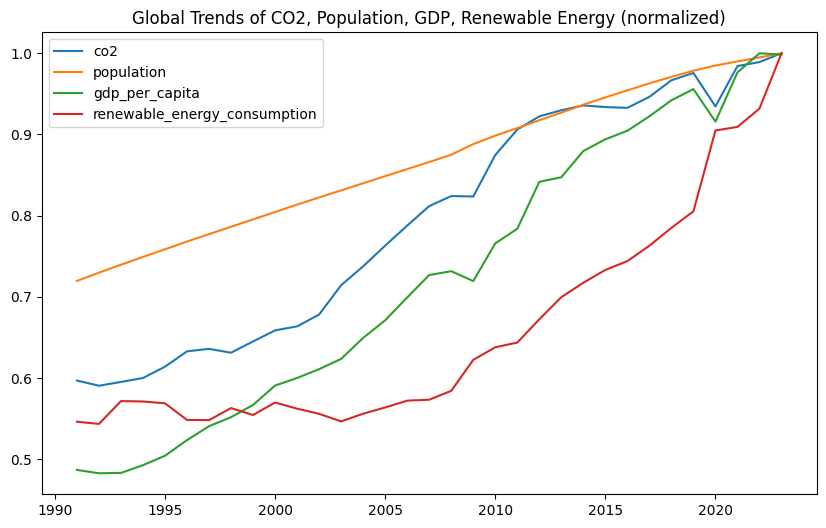

In [55]:
# Visualizing global trends

global_trends = fulldata_df.groupby("year")[["co2", "population", "gdp_per_capita", "renewable_energy_consumption"]].sum()
plt.figure(figsize=(10,6))
normalized=global_trends / global_trends.max()
for col in normalized.columns:
    plt.plot(normalized.index, normalized[col], label=col)
plt.title("Global Trends of CO2, Population, GDP, Renewable Energy (normalized)")
plt.legend()
plt.savefig('Global_Trends_of_CO2_Population_GDP_Renewable_Energy_normalized.png', dpi=300)
plt.show()

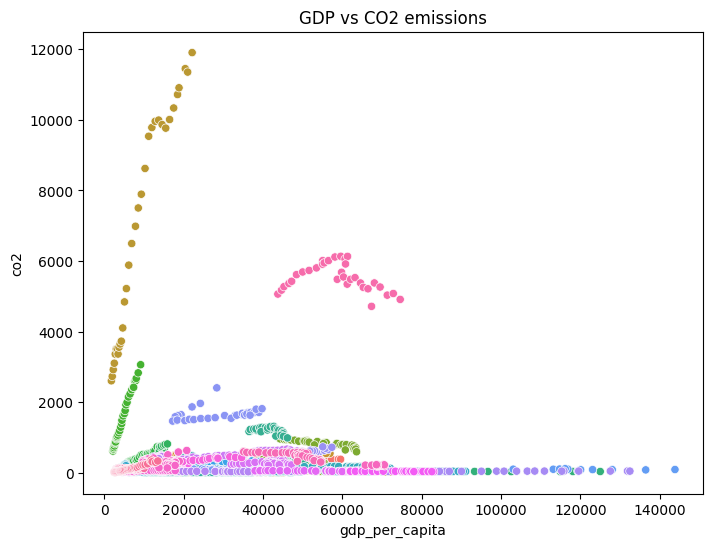

In [56]:
# Visualizing GDP vs CO2 emissions

plt.figure(figsize=(8,6))
sns.scatterplot(data=fulldata_df, x="gdp_per_capita", y="co2", hue="country", legend=False)
plt.title("GDP vs CO2 emissions")
plt.savefig("GDP_vs_CO2_emissions.png", dpi=300)
plt.show()

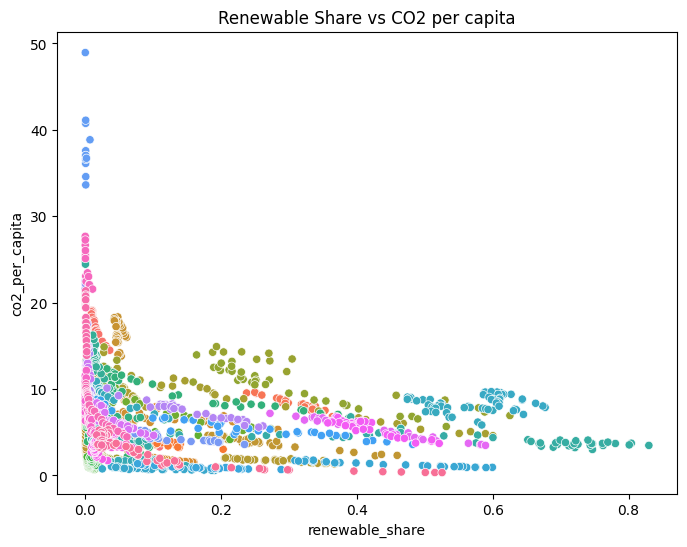

In [57]:
# Visualizing Renewable Share vs CO2 per capita

plt.figure(figsize=(8,6))
sns.scatterplot(data=fulldata_df, x="renewable_share", y="co2_per_capita", hue="country", legend=False)
plt.title("Renewable Share vs CO2 per capita")
plt.savefig("Renewable_Share_vs_CO2_per_capita.png", dpi=300)
plt.show()

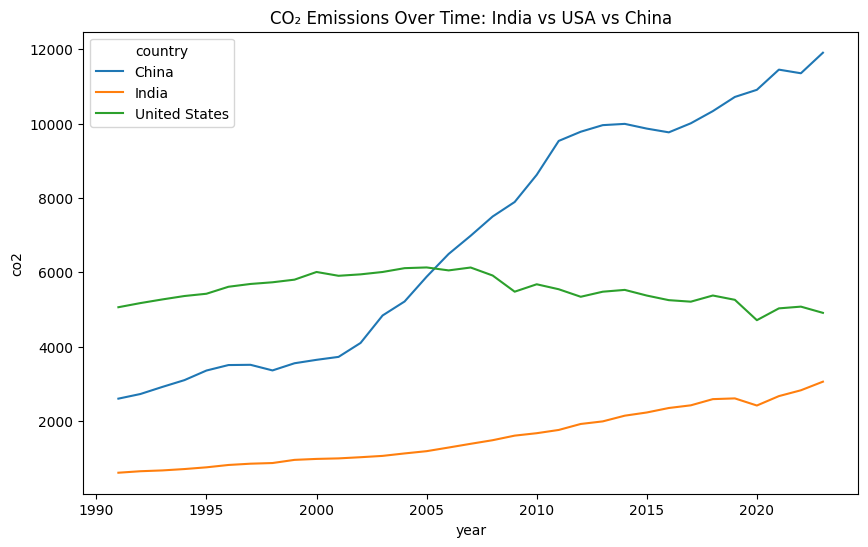

In [58]:
# Visualizing CO₂ emissions over time for specific countries (India, United States, China)

case_countries = ["India", "United States", "China"]
case_df = fulldata_df[fulldata_df["country"].isin(case_countries)]

plt.figure(figsize=(10,6))
sns.lineplot(data=case_df, x="year", y="co2", hue="country")
plt.title("CO₂ Emissions Over Time: India vs USA vs China")
plt.savefig("CO2_Emissions_Over_Time_India_vs_USA_vs_China.png", dpi=300)
plt.show()

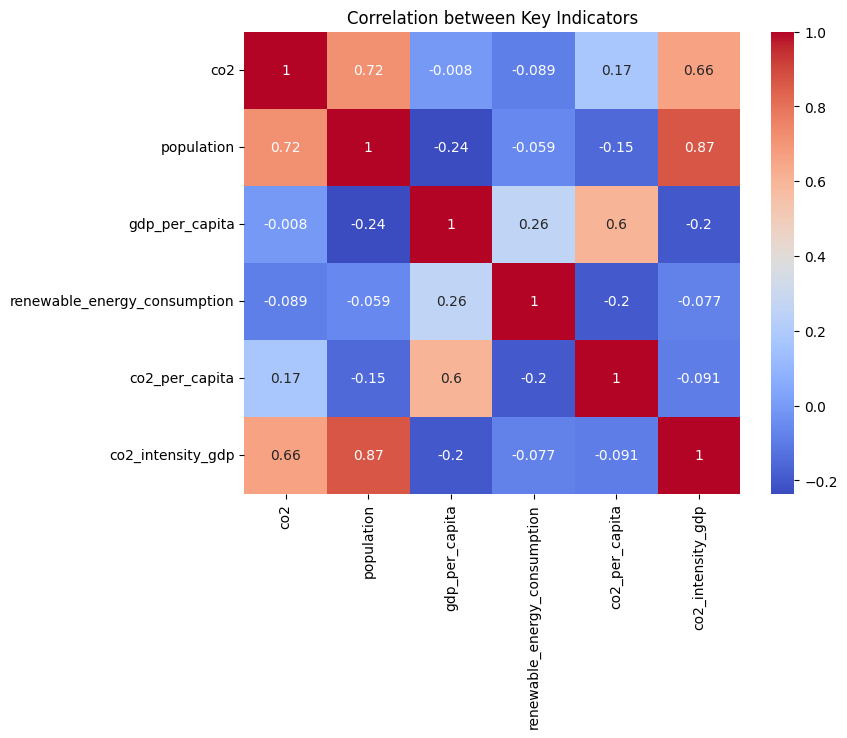

In [59]:
# Correlation heatmap of key indicators

plt.figure(figsize=(8,6))
sns.heatmap(fulldata_df[["co2","population","gdp_per_capita","renewable_energy_consumption",
                       "co2_per_capita","co2_intensity_gdp"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation between Key Indicators")
plt.savefig("Correlation_between_Key_Indicators.png", dpi=300)
plt.show()

### 2.4 Clustering
We apply **KMeans clustering** on standardized indicators. 
PCA is used to reduce dimensionality to 2 components for visualization. 
This reveals groups of countries with similar climate-energy profiles.
We tested k=2-10 using both thw elbow method(inertia) and the silhouette score. 

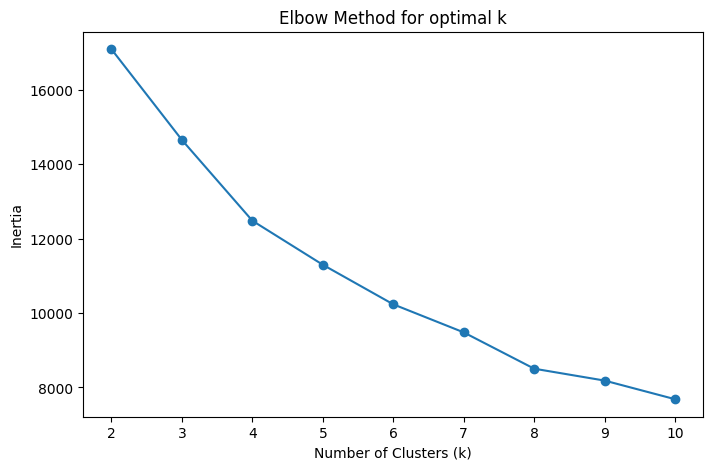

Silhouette Scores:  {2: 0.2818014204575632, 3: 0.3122886558429391, 4: 0.22682248800499144, 5: 0.23193316772307426, 6: 0.23988366981442008, 7: 0.23405310409009708, 8: 0.23994336736052488, 9: 0.22007926031037628, 10: 0.22580103136448437}


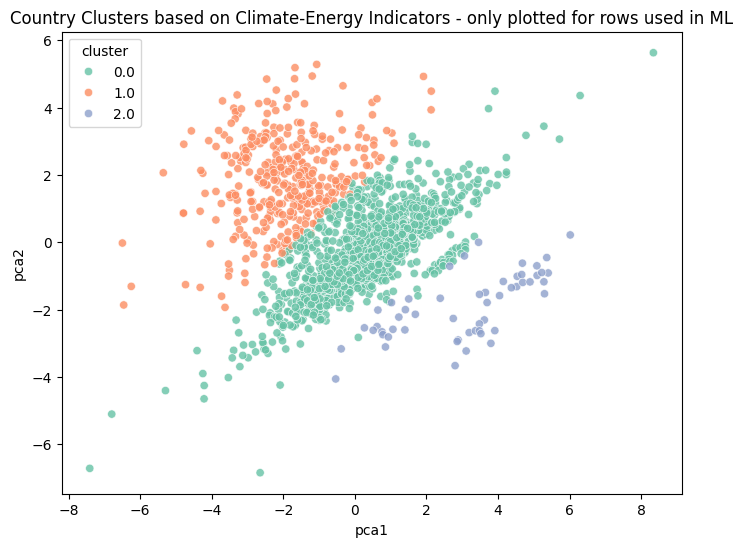

Cluster Profiles (centroid values):
   co2_growth  co2_per_capita_growth  ...  log_gdp_per_capita  cumulative_co2
0       0.013                  0.003  ...               9.990        5355.836
1      -0.012                 -0.018  ...              10.502         849.635
2       0.031                  0.024  ...               9.626      106091.819

[3 rows x 10 columns]


In [60]:
from sklearn.metrics import silhouette_score

features = ["co2_growth","co2_per_capita_growth","gdp_growth","renewable_growth",
            "renewable_share","population_growth","fossil_dependency","co2_intensity_gdp",
            "log_gdp_per_capita","cumulative_co2"]
df_main=fulldata_df_clean
X = df_main[features].copy()
X = X.replace([np.inf, -np.inf], np.nan)
X = X.dropna()
valid_idx = X.index
X = X.clip(lower=-1e12, upper=1e12)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Finding optimal number of clusters
silhouette_scores={}
inertia_scores=[]
for k in range (2,11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    silhouette_scores[k] = silhouette_score(X_scaled, labels)
    inertia_scores.append(kmeans.inertia_)

# Plotting the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), inertia_scores, marker='o')
plt.title('Elbow Method for optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

# Print silhouette score
print("Silhouette Scores: ", silhouette_scores)


# K-Means Clustering
optimal_k=3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)
df_main.loc[valid_idx, 'cluster'] = labels

# PCA for Visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
df_main.loc[valid_idx, 'pca1'] = X_pca[:, 0]
df_main.loc[valid_idx, 'pca2'] = X_pca[:, 1]

plot_df=df_main.loc[valid_idx].copy()
plt.figure(figsize=(8, 6))
sns.scatterplot(data=plot_df, x='pca1', y='pca2', hue='cluster', palette='Set2', alpha=0.8)
plt.title('Country Clusters based on Climate-Energy Indicators - only plotted for rows used in ML')
plt.savefig("Country_Clusters_based_on_Climate_Energy_Indicators.png", dpi=300)
plt.show()

#Get cluster centers in original scale
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=features)
print("Cluster Profiles (centroid values):")
print(cluster_centers_df.round(3))

### 2.5 Anomaly Detection
We apply **Isolation Forest** on the same indicators. 
This identifies countries whose profiles deviate significantly from the global norm.
python
Copy code


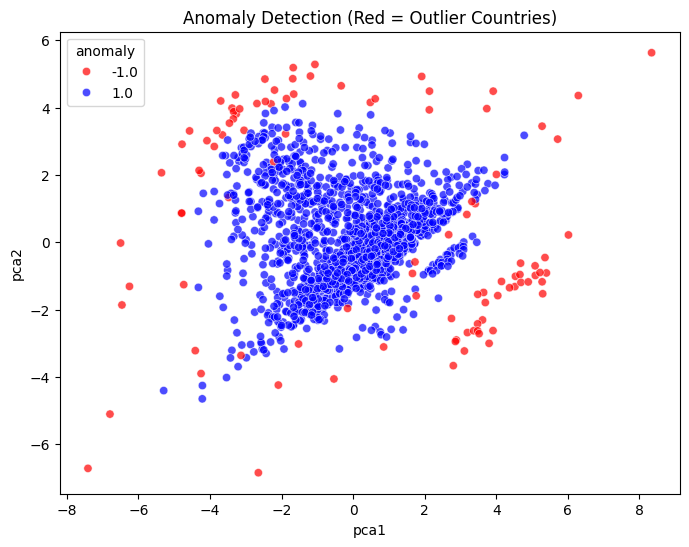

,country,year,co2_growth,co2_per_capita_growth,gdp_growth,renewable_growth,renewable_share,population_growth,fossil_dependency,co2_intensity_gdp,log_gdp_per_capita,cumulative_co2
8,Algeria,1998,0.205592,0.186412,0.034395,1.769371,0.001815,0.016053,99.998185,0.009602,9.314240,797.702
141,Azerbaijan,1995,-0.205889,-0.217305,-0.128134,-0.095818,0.074857,0.014508,99.925143,0.008030,8.330375,281.199
375,China,1991,0.048792,0.033426,0.077821,-0.063444,0.001597,0.014915,99.998403,1.469349,7.480789,5090.951
376,China,1992,0.047846,0.035490,0.128332,-0.002681,0.001520,0.011775,99.998480,1.364538,7.601529,7821.739
377,China,1993,0.069893,0.058568,0.125820,0.078441,0.001532,0.010750,99.998468,1.296753,7.720041,10743.390
378,China,1994,0.062324,0.052049,0.117664,0.041188,0.001502,0.009767,99.998498,1.232545,7.831282,13847.129
379,China,1995,0.083093,0.073237,0.097550,0.122422,0.001556,0.009207,99.998444,1.216310,7.924362,17208.766
380,China,1996,0.043783,0.034846,0.087764,-0.074467,0.001380,0.008860,99.998620,1.167131,8.008486,20717.584
381,China,1997,0.001931,-0.006314,0.081245,0.042889,0.001436,0.008282,99.998564,1.081517,8.086599,24233.178
382,China,1998,-0.042953,-0.050477,0.068161,0.012295,0.001519,0.007821,99.998481,0.969013,8.152537,27597.765


In [61]:
iso = IsolationForest(contamination=0.05, random_state=42)
valid_idx = X.index
anomaly_labels = iso.fit_predict(X_scaled)
fulldata_df_clean.loc[valid_idx, "anomaly"] = anomaly_labels

# Map anomalies
plt.figure(figsize=(8,6))
sns.scatterplot(data=fulldata_df_clean, x="pca1", y="pca2", hue="anomaly", palette={1:"blue",-1:"red"}, alpha=0.7)
plt.title("Anomaly Detection (Red = Outlier Countries)")
plt.savefig("Anomaly_Detection.png", dpi=300)
plt.show()

# List anomalous countries
outliers = fulldata_df_clean[fulldata_df_clean["anomaly"]==-1][["country","year"]+features]
outliers.head(10)

### 3. Results  

#### Clustering  
Optimal cluster count was determined using the silhouette score (highest at k=3, score = 0.31). The resulting clusters were:  

- **Cluster 0 – Mid-industrializing economies**  
  - CO₂ growth: +0.013  
  - GDP per capita (log): 9.99  
  - Cumulative CO₂: ~5356  
  - Interpretation: Countries with moderate economic output, medium cumulative emissions, and slightly increasing emissions.  

- **Cluster 1 – Developed transitioning economies**  
  - CO₂ growth: –0.012  
  - GDP per capita (log): 10.50  
  - Cumulative CO₂: ~850  
  - Interpretation: Wealthy economies with high GDP per capita, declining CO₂ emissions, and relatively low historical emissions — consistent with transitions toward renewable energy.  

- **Cluster 2 – High-emission legacy economies**  
  - CO₂ growth: +0.031  
  - GDP per capita (log): 9.63  
  - Cumulative CO₂: ~106,092  
  - Interpretation: Economies with the largest historical contributions to emissions and still-rising CO₂, despite lower GDP per capita compared to advanced economies.  

#### Anomaly Detection  
Isolation Forest identified outliers concentrated in specific years for a small set of countries. These anomalies reflected instances of sudden emission surges or reductions, often associated with geopolitical events, industrial restructuring, or large-scale adoption of renewable energy.  


### 4. Conclusion  

This study demonstrates that clustering and anomaly detection can provide meaningful structural insights into global CO₂ emission dynamics. The clustering analysis revealed three distinct groups of economies: mid-industrializing economies with steady growth in emissions, developed economies with high income but declining emissions, and historically high-emission economies still contributing substantially to global CO₂.  

Anomaly detection highlighted country-years that deviated sharply from cluster trends, pointing to disruptive events or policy changes influencing emission behavior.  

Overall, this approach shows that machine learning can enrich traditional sustainability analyses by uncovering latent structures and irregularities in complex environmental datasets. The findings emphasize both the diversity of national emission pathways and the importance of tailored mitigation strategies.  